# GAN on Harmful Behavior

In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
from datasets.behavior import *

In [3]:
CUDA = False
DATA_PATH = './data'
BATCH_SIZE = 16
IMAGE_CHANNEL = 1
Z_DIM = 8
G_HIDDEN = 64
D_HIDDEN = 64
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4

In [4]:
CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 1.12.1


In [5]:
# Data preprocessing
dataset = BehaviourDataset('./behavior.csv', harmful_only=True)

# Dataloader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

### Generator and Discriminator

In [34]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            torch.nn.Linear(Z_DIM, 16),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(0.2),
            torch.nn.Linear(16, 32),
            nn.LeakyReLU(0.2),
            torch.nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            torch.nn.Linear(64, 105),
        )

    def forward(self, input):
        return self.main(input)

In [35]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            torch.nn.Linear(105, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [87]:
# Create the generator
netG = Generator().to(device)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
print(netD)

Generator(
  (main): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=32, out_features=64, bias=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Linear(in_features=64, out_features=105, bias=True)
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=105, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=1, bias=True)
    (6): Sigmoid()
  )
)


In [88]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, 1, 1, Z_DIM, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [89]:
EPOCH_NUM = 20

In [90]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):
        # (1) Update the discriminator with real data
        netG.train(True)
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 1, 1, Z_DIM, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # (3) Update the generator with fake data
        netG.zero_grad()
        label.fill_(REAL_LABEL)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1
        
        # clear_output(True)
        # plt.plot(G_losses, label='generator')
        # plt.plot(D_losses, label='discriminator')
        # plt.legend()
        # plt.show()

Starting Training Loop...
[0/20][0/1680]	Loss_D: 1.3842	Loss_G: 0.6909	D(x): 0.5026	D(G(z)): 0.5015 / 0.5011
[0/20][50/1680]	Loss_D: 1.3774	Loss_G: 0.6980	D(x): 0.5025	D(G(z)): 0.4980 / 0.4976
[0/20][100/1680]	Loss_D: 1.3807	Loss_G: 0.6964	D(x): 0.5017	D(G(z)): 0.4989 / 0.4984
[0/20][150/1680]	Loss_D: 1.3787	Loss_G: 0.6965	D(x): 0.5033	D(G(z)): 0.4994 / 0.4983
[0/20][200/1680]	Loss_D: 1.3776	Loss_G: 0.7014	D(x): 0.5020	D(G(z)): 0.4976 / 0.4959
[0/20][250/1680]	Loss_D: 1.3495	Loss_G: 0.7212	D(x): 0.5090	D(G(z)): 0.4903 / 0.4862
[0/20][300/1680]	Loss_D: 1.4031	Loss_G: 0.6871	D(x): 0.5060	D(G(z)): 0.5133 / 0.5031
[0/20][350/1680]	Loss_D: 1.3133	Loss_G: 0.7681	D(x): 0.5082	D(G(z)): 0.4686 / 0.4639
[0/20][400/1680]	Loss_D: 1.3509	Loss_G: 0.7012	D(x): 0.5267	D(G(z)): 0.5052 / 0.4962
[0/20][450/1680]	Loss_D: 1.3510	Loss_G: 0.7506	D(x): 0.5056	D(G(z)): 0.4853 / 0.4723
[0/20][500/1680]	Loss_D: 1.3280	Loss_G: 0.7588	D(x): 0.5285	D(G(z)): 0.4937 / 0.4700
[0/20][550/1680]	Loss_D: 1.3166	Loss_G: 0.

[2/20][1400/1680]	Loss_D: 1.0868	Loss_G: 0.8196	D(x): 0.6545	D(G(z)): 0.4421 / 0.4407
[2/20][1450/1680]	Loss_D: 0.7696	Loss_G: 0.9298	D(x): 0.7903	D(G(z)): 0.4020 / 0.3951
[2/20][1500/1680]	Loss_D: 1.1290	Loss_G: 1.0449	D(x): 0.5947	D(G(z)): 0.3867 / 0.3534
[2/20][1550/1680]	Loss_D: 1.0162	Loss_G: 1.0059	D(x): 0.6259	D(G(z)): 0.3663 / 0.3665
[2/20][1600/1680]	Loss_D: 0.9953	Loss_G: 0.9294	D(x): 0.6836	D(G(z)): 0.4292 / 0.3954
[2/20][1650/1680]	Loss_D: 1.2311	Loss_G: 0.9350	D(x): 0.5803	D(G(z)): 0.4528 / 0.3963
[3/20][0/1680]	Loss_D: 1.3717	Loss_G: 0.9912	D(x): 0.4188	D(G(z)): 0.3712 / 0.3716
[3/20][50/1680]	Loss_D: 0.9542	Loss_G: 0.8520	D(x): 0.7315	D(G(z)): 0.4433 / 0.4283
[3/20][100/1680]	Loss_D: 0.8863	Loss_G: 0.9621	D(x): 0.7278	D(G(z)): 0.3940 / 0.3831
[3/20][150/1680]	Loss_D: 1.1195	Loss_G: 0.9392	D(x): 0.5926	D(G(z)): 0.3921 / 0.3917
[3/20][200/1680]	Loss_D: 1.2052	Loss_G: 0.9206	D(x): 0.5445	D(G(z)): 0.3987 / 0.3983
[3/20][250/1680]	Loss_D: 1.3580	Loss_G: 0.9135	D(x): 0.5057	D(

[5/20][1200/1680]	Loss_D: 0.8800	Loss_G: 1.1427	D(x): 0.7029	D(G(z)): 0.3210 / 0.3205
[5/20][1250/1680]	Loss_D: 1.2683	Loss_G: 1.1670	D(x): 0.4862	D(G(z)): 0.3694 / 0.3143
[5/20][1300/1680]	Loss_D: 0.7747	Loss_G: 1.0601	D(x): 0.7774	D(G(z)): 0.3766 / 0.3532
[5/20][1350/1680]	Loss_D: 0.9084	Loss_G: 1.1002	D(x): 0.6972	D(G(z)): 0.3710 / 0.3367
[5/20][1400/1680]	Loss_D: 1.2710	Loss_G: 1.1350	D(x): 0.5157	D(G(z)): 0.3841 / 0.3264
[5/20][1450/1680]	Loss_D: 1.1586	Loss_G: 1.2366	D(x): 0.5225	D(G(z)): 0.2903 / 0.2908
[5/20][1500/1680]	Loss_D: 1.0028	Loss_G: 1.0713	D(x): 0.6416	D(G(z)): 0.3432 / 0.3426
[5/20][1550/1680]	Loss_D: 0.6740	Loss_G: 1.1909	D(x): 0.7867	D(G(z)): 0.3060 / 0.3042
[5/20][1600/1680]	Loss_D: 1.0927	Loss_G: 1.0424	D(x): 0.6299	D(G(z)): 0.3962 / 0.3647
[5/20][1650/1680]	Loss_D: 1.2182	Loss_G: 1.1224	D(x): 0.4906	D(G(z)): 0.3252 / 0.3256
[6/20][0/1680]	Loss_D: 0.9014	Loss_G: 1.0741	D(x): 0.7070	D(G(z)): 0.3424 / 0.3419
[6/20][50/1680]	Loss_D: 0.6149	Loss_G: 1.0261	D(x): 0.874

[8/20][950/1680]	Loss_D: 0.2387	Loss_G: 2.9434	D(x): 0.9408	D(G(z)): 0.0532 / 0.0528
[8/20][1000/1680]	Loss_D: 0.2766	Loss_G: 2.9566	D(x): 0.9402	D(G(z)): 0.0726 / 0.0530
[8/20][1050/1680]	Loss_D: 0.2472	Loss_G: 3.0543	D(x): 0.9401	D(G(z)): 0.0474 / 0.0473
[8/20][1100/1680]	Loss_D: 0.2779	Loss_G: 2.9959	D(x): 0.9391	D(G(z)): 0.0577 / 0.0541
[8/20][1150/1680]	Loss_D: 0.4853	Loss_G: 2.9483	D(x): 0.8790	D(G(z)): 0.0545 / 0.0544
[8/20][1200/1680]	Loss_D: 0.5466	Loss_G: 2.7158	D(x): 0.8589	D(G(z)): 0.1563 / 0.0788
[8/20][1250/1680]	Loss_D: 0.3426	Loss_G: 3.1526	D(x): 0.8735	D(G(z)): 0.0491 / 0.0467
[8/20][1300/1680]	Loss_D: 0.5254	Loss_G: 2.9772	D(x): 0.8786	D(G(z)): 0.0953 / 0.0548
[8/20][1350/1680]	Loss_D: 0.7443	Loss_G: 2.7591	D(x): 0.7661	D(G(z)): 0.0643 / 0.0646
[8/20][1400/1680]	Loss_D: 0.5508	Loss_G: 2.6948	D(x): 0.8263	D(G(z)): 0.0693 / 0.0689
[8/20][1450/1680]	Loss_D: 0.3455	Loss_G: 2.7756	D(x): 0.8848	D(G(z)): 0.0640 / 0.0636
[8/20][1500/1680]	Loss_D: 0.4694	Loss_G: 2.7637	D(x): 0

[11/20][700/1680]	Loss_D: 1.0620	Loss_G: 1.2931	D(x): 0.5871	D(G(z)): 0.2740 / 0.2746
[11/20][750/1680]	Loss_D: 0.8485	Loss_G: 1.2062	D(x): 0.6886	D(G(z)): 0.3012 / 0.2994
[11/20][800/1680]	Loss_D: 0.9098	Loss_G: 1.2326	D(x): 0.6383	D(G(z)): 0.2901 / 0.2923
[11/20][850/1680]	Loss_D: 0.3265	Loss_G: 1.4618	D(x): 0.9455	D(G(z)): 0.2339 / 0.2322
[11/20][900/1680]	Loss_D: 0.3711	Loss_G: 1.6248	D(x): 0.9103	D(G(z)): 0.1986 / 0.1976
[11/20][950/1680]	Loss_D: 0.4356	Loss_G: 1.6692	D(x): 0.9665	D(G(z)): 0.2252 / 0.2007
[11/20][1000/1680]	Loss_D: 0.3068	Loss_G: 1.8682	D(x): 0.9404	D(G(z)): 0.1555 / 0.1545
[11/20][1050/1680]	Loss_D: 0.1458	Loss_G: 2.0478	D(x): 0.9951	D(G(z)): 0.1312 / 0.1299
[11/20][1100/1680]	Loss_D: 0.4479	Loss_G: 2.2982	D(x): 0.8830	D(G(z)): 0.1009 / 0.1005
[11/20][1150/1680]	Loss_D: 0.0824	Loss_G: 2.5457	D(x): 0.9999	D(G(z)): 0.0790 / 0.0785
[11/20][1200/1680]	Loss_D: 0.0734	Loss_G: 2.6624	D(x): 1.0000	D(G(z)): 0.0707 / 0.0704
[11/20][1250/1680]	Loss_D: 0.0683	Loss_G: 2.7373	

[14/20][350/1680]	Loss_D: 1.0477	Loss_G: 1.1768	D(x): 0.6092	D(G(z)): 0.3195 / 0.3095
[14/20][400/1680]	Loss_D: 0.9755	Loss_G: 1.1107	D(x): 0.6389	D(G(z)): 0.3298 / 0.3297
[14/20][450/1680]	Loss_D: 0.9151	Loss_G: 1.0452	D(x): 0.7090	D(G(z)): 0.3532 / 0.3524
[14/20][500/1680]	Loss_D: 1.0335	Loss_G: 1.0851	D(x): 0.6243	D(G(z)): 0.3384 / 0.3380
[14/20][550/1680]	Loss_D: 0.9409	Loss_G: 1.0925	D(x): 0.6685	D(G(z)): 0.3357 / 0.3354
[14/20][600/1680]	Loss_D: 0.5690	Loss_G: 1.2180	D(x): 0.8848	D(G(z)): 0.3182 / 0.2961
[14/20][650/1680]	Loss_D: 1.0650	Loss_G: 1.3184	D(x): 0.5788	D(G(z)): 0.2669 / 0.2677
[14/20][700/1680]	Loss_D: 1.1439	Loss_G: 1.1213	D(x): 0.5641	D(G(z)): 0.3263 / 0.3261
[14/20][750/1680]	Loss_D: 1.1994	Loss_G: 1.0911	D(x): 0.5310	D(G(z)): 0.3359 / 0.3360
[14/20][800/1680]	Loss_D: 1.1848	Loss_G: 1.0836	D(x): 0.5278	D(G(z)): 0.3382 / 0.3385
[14/20][850/1680]	Loss_D: 0.8661	Loss_G: 1.0387	D(x): 0.7258	D(G(z)): 0.3561 / 0.3603
[14/20][900/1680]	Loss_D: 0.7381	Loss_G: 1.2432	D(x): 

[17/20][0/1680]	Loss_D: 0.3495	Loss_G: 1.6674	D(x): 0.9405	D(G(z)): 0.2099 / 0.1891
[17/20][50/1680]	Loss_D: 0.3938	Loss_G: 1.6713	D(x): 0.9381	D(G(z)): 0.2371 / 0.1923
[17/20][100/1680]	Loss_D: 0.4614	Loss_G: 1.7188	D(x): 0.8803	D(G(z)): 0.2119 / 0.1830
[17/20][150/1680]	Loss_D: 1.1864	Loss_G: 1.7176	D(x): 0.5492	D(G(z)): 0.2195 / 0.1884
[17/20][200/1680]	Loss_D: 0.7478	Loss_G: 1.4068	D(x): 0.7617	D(G(z)): 0.2556 / 0.2477
[17/20][250/1680]	Loss_D: 0.8083	Loss_G: 1.2645	D(x): 0.7248	D(G(z)): 0.2834 / 0.2829
[17/20][300/1680]	Loss_D: 1.2209	Loss_G: 1.1872	D(x): 0.4893	D(G(z)): 0.3048 / 0.3052
[17/20][350/1680]	Loss_D: 0.9841	Loss_G: 1.1852	D(x): 0.6251	D(G(z)): 0.3064 / 0.3062
[17/20][400/1680]	Loss_D: 0.9652	Loss_G: 1.1794	D(x): 0.6345	D(G(z)): 0.3107 / 0.3101
[17/20][450/1680]	Loss_D: 1.0434	Loss_G: 1.1310	D(x): 0.5946	D(G(z)): 0.3237 / 0.3234
[17/20][500/1680]	Loss_D: 0.7857	Loss_G: 1.0943	D(x): 0.7610	D(G(z)): 0.3357 / 0.3348
[17/20][550/1680]	Loss_D: 1.0466	Loss_G: 1.0972	D(x): 0.5

[19/20][1350/1680]	Loss_D: 0.2546	Loss_G: 2.5884	D(x): 0.9263	D(G(z)): 0.0761 / 0.0756
[19/20][1400/1680]	Loss_D: 0.2381	Loss_G: 2.6478	D(x): 0.9413	D(G(z)): 0.0718 / 0.0713
[19/20][1450/1680]	Loss_D: 0.4194	Loss_G: 2.6875	D(x): 0.8830	D(G(z)): 0.0684 / 0.0684
[19/20][1500/1680]	Loss_D: 0.3312	Loss_G: 2.7020	D(x): 0.8994	D(G(z)): 0.0674 / 0.0671
[19/20][1550/1680]	Loss_D: 0.2359	Loss_G: 2.7810	D(x): 0.9415	D(G(z)): 0.0626 / 0.0622
[19/20][1600/1680]	Loss_D: 0.2676	Loss_G: 2.7362	D(x): 0.9309	D(G(z)): 0.0793 / 0.0663
[19/20][1650/1680]	Loss_D: 0.3836	Loss_G: 2.5659	D(x): 0.8750	D(G(z)): 0.1160 / 0.0809


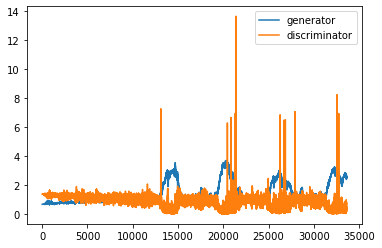

In [91]:
plt.plot(G_losses, label='generator')
plt.plot(D_losses, label='discriminator')
plt.legend()

In [102]:
torch.save(netG, './models/GAN_Behavior_40_epoch.pth')

# Metrics

In [92]:
from common.metrics import *
from torch.distributions import normal
import os

In [78]:
model = torch.load('./models/GAN_Behavior_40_epoch.pth')
model.eval()

Generator(
  (main): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=64, out_features=105, bias=True)
  )
)

In [93]:
viz_noise = torch.rand(1024, 1, 1, Z_DIM, device=device)

In [94]:
with torch.no_grad():
    generated_behavior = netG(viz_noise).view(1024, 1, 105)

In [95]:
generated_behavior

tensor([[[-0.0222, -0.0593,  0.0425,  ..., -0.1076, -0.1116,  0.0272]],

        [[ 0.0632, -0.0666,  0.0255,  ..., -0.1215, -0.0623,  0.0368]],

        [[ 0.0246, -0.0387,  0.0407,  ..., -0.1148, -0.1127,  0.0492]],

        ...,

        [[-0.0217, -0.0535,  0.0512,  ..., -0.1083, -0.1076,  0.0323]],

        [[-0.0753, -0.0211,  0.0587,  ..., -0.1075, -0.1405,  0.0268]],

        [[ 0.0602, -0.0690,  0.0172,  ..., -0.1289, -0.0496,  0.0368]]])

In [101]:
min_dist = behavior_dist(generated_behavior, dataloader)

In [20]:
print(f'min dist to real sample vector is {min_dist}')

min dist to real sample vector is 10.99467658996582


In [96]:
current_path = !pwd
clf_path = os.path.join(current_path[0], 'models/behavior_clf_40_epoch.pth')

In [97]:
probs = harmful_behavior_probs(generated_behavior, clf_path)

In [103]:
print(f'mean classifier harmful behavior prob {probs.mean()}')

mean classifier harmful behavior prob 0.9482505321502686


In [105]:
plt.rcParams['figure.figsize'] = [10, 7]

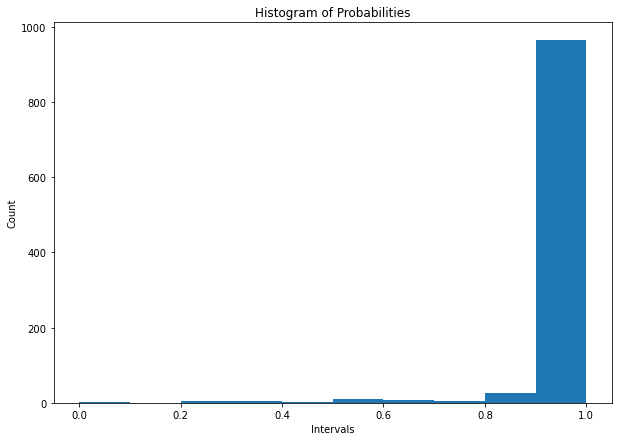

In [106]:
# Step 1: Convert probability values to floats
probabilities = [str(x.item()) for x in probs]
probabilities = [float(prob.replace(',', '.')) for prob in probabilities]

# Step 2: Create intervals from 0 to 1 with step size 0.1
intervals = [i / 10 for i in range(11)]

# Step 3: Count the values within each interval
counts = [0] * (len(intervals) - 1)
for prob in probabilities:
    for i in range(len(intervals) - 1):
        if intervals[i] <= prob < intervals[i + 1]:
            counts[i] += 1
            break

# Step 4: Plot the histogram
plt.bar(intervals[:-1], counts, align='edge', width=0.1)
plt.xlabel('Intervals')
plt.ylabel('Count')
plt.title('Histogram of Probabilities')
plt.show()